In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
tf.enable_v2_behavior()
import numpy as np
import lanczos_algorithm

['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
(50000, 32, 32, 3)
Train data (binary) shape:  (4910, 3072)
Train labels (binary) shape:  (4910,)
Validation data (binary) shape:  (90, 3072)
Validation labels (binary) shape:  (90,)
(4910, 3073) (90, 3073)


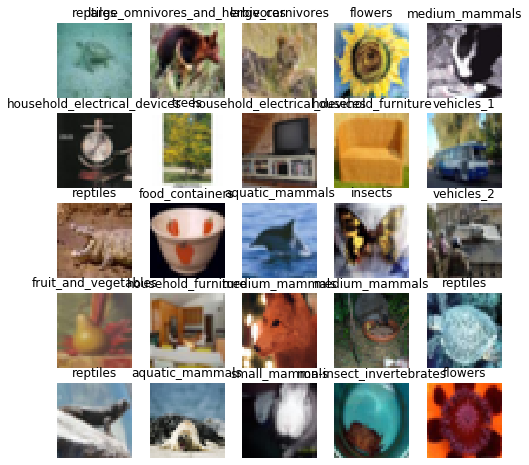

In [44]:
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
    
import pickle
import os
import tarfile
import urllib.request as url
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res
        
def load_data():
    os.chdir('./')
    meta = unpickle('./data/cifar-100-python/meta')
    coarse_label_names = [t.decode('utf8') for t in meta[b'coarse_label_names']]

    train = unpickle('./data/cifar-100-python//train')
    y_train = np.array(train[b'coarse_labels'])
    X_train = np.array(train[b'data'])

    test = unpickle('./data/cifar-100-python//test')
    y_test = np.array(test[b'coarse_labels'])
    X_test = np.array(test[b'data'])
    
    return coarse_label_names, X_train, y_train, X_test, y_test  




synthetic = False

if synthetic:
    num_samples = 1000
    num_features = 70
    num_informative = 10



    x, y, coef = datasets.make_regression(n_samples=num_samples,      #number of samples
                                          n_features=num_features,    #number of features
                                          n_informative=num_informative, #number of useful features 
                                          noise=5,                   #bias and standard deviation of the guassian noise
                                          coef=True,                  #true coefficient used to generated the data
                                          random_state=0)             #set for same data points for each run

    XX = np.interp(x, (x.min(), x.max()), (0, 20))
    yy = np.interp(y, (y.min(), y.max()), (0, 20))
    
    # Split the data into training/testing sets
    X = XX[:-100]
    X_test = XX[-100:]

    # Split the targets into training/testing sets
    y = yy[:-100]
    y_test = yy[-100:]
    
    num_samples = 900

#     print(x.shape)
#     print(y.shape)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(-155, -20)
#     ax.scatter(X[:,0],X[:,1],y)
#     plt.show()
#     plt.ion() #interactive plot on
#     plt.plot(x,y,'.',label='training data')
#     plt.xlabel('x');plt.ylabel('y')
    

else:
    #CIFAR 100

    # Load the raw CIFAR-100 data. 
    label_map, X_train, y_train, X_test, y_test = load_data()

    # I flattened 1×32×32×3 images into 1×3072 Numpy arrays. Number 3 stands for 3 color channels.
    # reshape vectorized data into the image format
    X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1)

    print(label_map)
    print(X.shape)

    #Visualizing CIFAR 100 data. Randomly choose 25 images from the train dataset to show.
    fig, axes1 = plt.subplots(5,5,figsize=(8,8))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(X)))
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(X[i:i+1][0])
            axes1[j][k].set_title(label_map[y_train[i]])
    
    
    num_training = 49000
    num_validation = 1000
    num_test = 1000

    X_val = X_train[-num_validation:, :]
    y_val = y_train[-num_validation:]


    X_train = X_train[:num_training, :]
    y_train = y_train[:num_training]

    X_test = X_test[:num_test, :]
    y_test = y_test[:num_test]


    # Subsample 10-class training set to 2-class training set
    X_train_binary = X_train[y_train<2,:]
    num_training_binary = X_train_binary.shape[0]
    y_train_binary = y_train[y_train<2]

    X_val_binary = X_val[y_val<2,:]
    y_val_binary = y_val[y_val<2]


    print('Train data (binary) shape: ', X_train_binary.shape)
    print('Train labels (binary) shape: ', y_train_binary.shape)
    print('Validation data (binary) shape: ', X_val_binary.shape)
    print('Validation labels (binary) shape: ', y_val_binary.shape)

    # Preprocessing: subtract the mean value across every dimension, for binary training data
    mean_image = np.mean(X_train_binary, axis=0)

    X_train_binary = X_train_binary.astype(np.float32) - mean_image.astype(np.float32)
    X_val_binary = X_val_binary.astype(np.float32) - mean_image

    X_train_binary = np.hstack([X_train_binary, np.ones((X_train_binary.shape[0], 1))])
    X_val_binary = np.hstack([X_val_binary, np.ones((X_val_binary.shape[0], 1))])
    print(X_train_binary.shape, X_val_binary.shape)
    num_dim = X_train_binary.shape[1]
    

In [42]:
def sigmoid(x):
    h = np.zeros_like(x)
    h = (1.0 / (1.0 + np.exp(-x) ) )
    return h 

class LogisticRegressionClassifier(object):
    def __init__(self):
        self.W = None

    def fit(self, X, y, learning_rate=1e-3, num_iters=100,
              batch_size=200, verbose=False):
     
            
        num_train, dim = X.shape
        num_classes = np.max(y) + 1  

        # Initialize W 
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        
        for it in range(num_iters):
        
            index_range = np.random.choice(num_train, batch_size) #generate indices
            X_batch = X[index_range, :]
            y_batch = y[index_range]

        
            # evaluate loss and gradient
            loss, dW = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            
            self.W -= learning_rate * dW

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        pred = X @ self.W
        if pred.ndim==1:
            print(pred.shape, self.W.shape)
            return pred
        return (pred).argmax(axis = 1)

    
    def loss(self, X, y, reg):

        loss = 0
        dW = np.zeros_like(self.W)


        z = X @ self.W
        h = sigmoid(z)
        m = y.shape[0]
        # calculate loss from fomula
        loss = 1/m*(-y.T @ np.log(h[:,1:2]) - (1 - y).T @ np.log(1 - h[:,1:2]))

        y_2class = np.zeros((m, 2))
        y_2class[:,0], y_2class[:,1] = 1-y, y 
        # calculate dW from fomula
        dW = 1/m*(X.T @ (h - y_2class))

        return loss, dW

In [41]:
classifier = LogisticRegressionClassifier()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_gd = classifier.fit(X=X_train_binary, y=y_train_binary, learning_rate=lr,batch_size=X_train_binary.shape[0], num_iters=1500, verbose=True)

y_train_pred = classifier.predict(X_train_binary)
print('training accuracy: %f' % (np.mean(y_train_binary == y_train_pred), ))
# y_val_pred = classifier.predict(X_val_binary)
# print('validation accuracy: %f' % (np.mean(y_val_binary == y_val_pred), ))

iteration 0 / 1500: loss 1.643749
iteration 100 / 1500: loss 0.946926
iteration 200 / 1500: loss 0.867819
iteration 300 / 1500: loss 0.815795
iteration 400 / 1500: loss 0.798587
iteration 500 / 1500: loss 0.775242
iteration 600 / 1500: loss 0.762378
iteration 700 / 1500: loss 0.723672
iteration 800 / 1500: loss 0.729871
iteration 900 / 1500: loss 0.730951
iteration 1000 / 1500: loss 0.729074
iteration 1100 / 1500: loss 0.695990
iteration 1200 / 1500: loss 0.726303
iteration 1300 / 1500: loss 0.710455
iteration 1400 / 1500: loss 0.712554
(4910, 3073)
training accuracy: 0.661303


(4910, 3073) (3073, 2) (4910,)
[6.89812594e+11 3.23155093e+11 2.29967205e+11 ... 1.43796516e+04
 1.51343670e+04 1.51199282e+04]


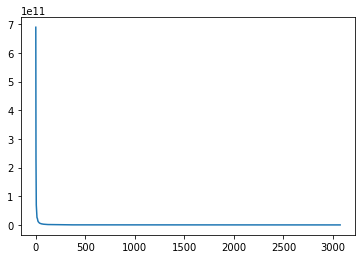

In [35]:
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh

def hessain(X, h_x):
        return X.T * h_x * (1 - h_x) @ X
mu = []
for x in X_train_binary:
    mu.append(hessain(x,sigmoid(x)))
S = np.array(mu)
print(X.shape,classifier.W.shape,S.shape)

H = X_train_binary.T*S@X_train_binary
# print(H)

w,v = np.linalg.eig(H)
# print(v*w@v.T-H)
print(w)
H_til=H/w[0]

num_eigen = np.linspace(0,len(w),len(w))
plt.plot(num_eigen,w)

2.840142870808462


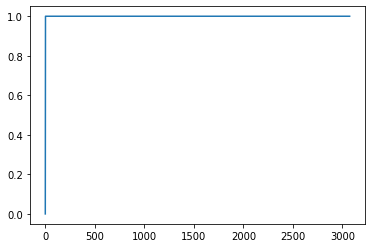

In [36]:
#low pass filter
w_til, v_til= np.linalg.eig(H_til)
# print(w_til)
energysum = np.sum(w_til[1:])
print(energysum)
for i in range(len(w_til)):
    if w_til[i]>energysum*0.2:
        w_til[i]= 0
    else:
        w_til[i]= 1
plt.plot(num_eigen,w_til)

In [37]:
import math

def compute_moments(A, v, deg):
    Amv = np.zeros((len(v), deg+1))
    for i in range(deg+1):
        if i == 0:
            Amv[:, i] = v
        else:
            Amv[:, i] = np.dot(A, Amv[:, i-1])

    return np.dot(v, Amv)


def compute_Chebyshev_moments(x):
    deg = len(x)
    Tk = np.zeros(deg)
    for k in range(deg):
        if k == 0:
            Tk[k] = 1
        elif k == 1:
            Tk[k] = x[k]
        else:
            for j in range(int(np.floor(k/2))+1):
                akj = (comb(2*j, j)*comb(k, 2*j)) / comb(k-1, j)
                Tk[k] = Tk[k] +\
                    ((-1)**j)*((2**(k-2*j-1))*(akj*x[k-2*j]))
    return Tk


def Chebyshev_step(deg, eps, damp):
    alpha1 = eps
    alpha2 = 1
    thetJ = math.pi/(deg+2)
    thetL = math.pi/(deg+1)
    a1 = 1/(deg+2)
    a2 = math.sin(thetJ)
    beta1 = math.acos(alpha1)
    beta2 = math.acos(alpha2)
    mu = np.zeros(deg+1)
    for k in range(deg+1):
        if damp == 0:
            jac = 1
        elif damp == 1:
            jac = a1*math.sin((k+1)*thetJ)/a2 + \
                (1-(k+1)*a1)*math.cos(k*thetJ)
        elif damp == 2:
            jac = 1
            if (k > 0):
                jac = math.sin(k*thetL)/(k*thetL)

        if k == 0:
            mu[k] = -jac*(beta2-beta1)/math.pi
        else:
            mu[k] = -2*jac*(
                math.sin(k*beta2)-math.sin(k*beta1))/(math.pi*k)

    return mu



In [50]:
from scipy.special import comb
from numpy import linalg as LA

S_H = v_til*w_til@v_til.T
# print(X.shape)

influence_x_H_inv = []
influence_x_SH = []
influence_x_Cheb = []

X = X_train_binary
y = y_train_binary

deg = 15
damp = 2
eps = 0.001
num_inf = int(num_training/200)
print(num_inf)
for i in range(num_inf):
    print(i)
#     xi = []
#     for j in range(X.shape[1]):
#         xi.append(X[i][j])
#     xi = np.array(xi)
    xx = X[i].reshape((1,num_dim))
    h = classifier.predict(xx)
#     print(h.shape,xx.shape)
    dli = -(y[i]-h)@xx
#     print(dli.shape,S_H.shape)

    #chebyshev step
    mom = compute_moments(S_H, dli, deg)
    cheb_mom = compute_Chebyshev_moments(mom)
    mu = Chebyshev_step(deg, eps, damp)
    approx = mu@cheb_mom

    influence_x_Cheb.append(approx)
    influence_x_H_inv.append(dli@np.linalg.inv(H)@dli)
    influence_x_SH.append(dli@S_H@dli)
    
# print(influence_x_H_inv/np.sum(influence_x_H_inv))
# print(influence_x_SH/np.sum(influence_x_SH))
x_axis = np.linspace(0,num_inf,num_inf)


p_H_inv = influence_x_H_inv/np.sum(influence_x_H_inv)
p_S_H = influence_x_SH/np.sum(influence_x_SH)
p_Cheb_H = influence_x_Cheb/np.sum(influence_x_Cheb)

ind_Hinv = np.argsort(p_H_inv)[::-1]
ind_S_H = np.argsort(p_S_H)[::-1]
ind_Cheb_H = np.argsort(p_Cheb_H)[::-1]

subsamp_per = 0.2
subsamp_num = int(num_inf*subsamp_per)
ind_Hinv_sub =  ind_Hinv[:subsamp_num]
ind_S_H_sub =  ind_S_H[:subsamp_num]
ind_Cheb_H_sub = ind_Cheb_H[:subsamp_num]


ind_Hinv_sub_s =  ind_Hinv[subsamp_num:]
ind_S_H_sub_s =  ind_S_H[subsamp_num:]
ind_Cheb_H_sub_s = ind_Cheb_H[subsamp_num:]

245
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244


0 0.0
1 0.0
2 0.010340291486719694
3 0.0
4 0.0
5 0.0
6 0.005626288596746313
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.002853475992462181
17 0.004304897529980789
18 0.0067138886540136855
19 0.0
20 0.0
21 0.01105753852741643
22 0.0
23 0.009954177437132056
24 0.016209894882675418
25 0.0
26 0.0
27 0.013655980772209515
28 0.0
29 0.0
30 0.0
31 0.011042437725624155
32 0.0
33 0.006878949049756974
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.008238673079014706
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0074882181700706065
48 0.0
49 0.012640042745963457
50 0.0
51 0.0
52 0.0
53 0.0026066602394902542
54 0.0
55 0.009660651840385491
56 0.0
57 0.009476126915454944
58 0.0
59 0.01157769369304957
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.021586066237992006
69 0.003102266727344895
70 0.010762233617971498
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.01908176200280145
82 0.0
83 0.030190402513221037
84 0.0033442855974034533
85 0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


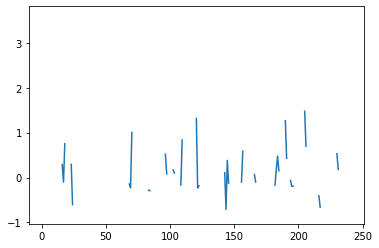

41 / 57
0.7192982456140351


In [54]:
relative_pi = []
for i in range(len(x_axis)):
    
    relative_pi.append((p_S_H[i]-p_H_inv[i])/p_H_inv[i])
    print(i,p_H_inv[i])
# plt.plot(x_axis, p_H_inv, label="h_inv")
# plt.plot(x_axis, p_S_H,c='r', label="S(H)")
# plt.legend()
plt.plot(x_axis,relative_pi, label='relative pi')
plt.show()

print(len(np.intersect1d(ind_Hinv_sub,ind_S_H_sub)),'/',len(np.union1d(ind_Hinv_sub,ind_S_H_sub)))
print(len(np.intersect1d(ind_Hinv_sub,ind_S_H_sub))/len(np.union1d(ind_Hinv_sub,ind_S_H_sub)))




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


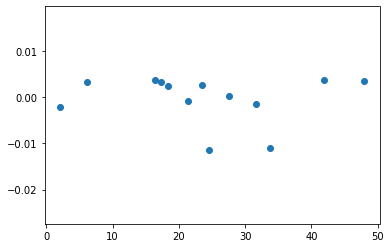

9 / 9
1.0


In [49]:
relative_pi = []
for i in range(len(x_axis)):
    relative_pi.append((p_Cheb_H[i]-p_S_H[i])/p_S_H[i])
    
# plt.plot(x_axis, p_S_H,c='r', label="S(H)")
# plt.plot(x_axis, p_Cheb_H,c = 'g', label="P_cheb(H)")
# plt.legend()
plt.scatter(x_axis,relative_pi, label='relative pi')
plt.show()

print(len(np.intersect1d(ind_Cheb_H_sub,ind_S_H_sub)),'/',len(np.union1d(ind_Cheb_H_sub,ind_S_H_sub)))
print(len(np.intersect1d(ind_Cheb_H_sub,ind_S_H_sub))/len(np.union1d(ind_Cheb_H_sub,ind_S_H_sub)))



